In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from metrics import get_smoothed_mean_log_accuracy_ratio
import shap
from features_extractor import FeatureExtractor

In [ ]:
validate = pd.read_csv('resources/validate.tsv', sep='\t')
validate_answers = pd.read_csv('resources/validate_answers.tsv', sep='\t')

In [ ]:
extractor = FeatureExtractor(history_path='resources/history.tsv', users_path='resources/users.tsv')

In [11]:
X = extractor.get_all_features(validate)
Y = validate_answers

KeyError: 'delay'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=142)

scaler = StandardScaler()
numerical_features = X_train.select_dtypes(include=np.number).columns
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])


In [72]:
from metrics import get_smoothed_mean_log_accuracy_ratio, get_smoothed_log_mape_column_value
from sklearn.metrics import make_scorer

def get_metric_for_ndarray(y_true, y_predicted):
    ans = get_smoothed_mean_log_accuracy_ratio(
        pd.DataFrame((y_true>0) * y_true, columns=Y.columns),
        pd.DataFrame((y_predicted>0) * y_predicted, columns=Y.columns)
    )
    return ans

def get_metric_for_one(y_true, y_predicted):
    return get_smoothed_log_mape_column_value((y_predicted>0)*y_predicted, (y_true>0)*y_true, 0.005)

In [136]:
param_grid = {
    'n_estimators': [2, 10, 20, 50, 100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    # 'criterion' : ['squared_error', 'absolute_error', 'friedman_mse', 'poisson']
}

# param_grid = {
#     'n_estimators': [2, 10, 20, 50, 100, 200, 300],
#     'max_depth': [None, 10, 20, 30, 40],
#     'min_samples_split': [2, 5, 10],
#     'max_features' : ['auto', 'sqrt', 'log2', None],
#     'max_leaf_nodes' : [None, 10, 20, 50, 100],
#     'min_impurity_decrease' : [0.0, 0.01, 0.05, 0.1],
#     'bootstrap' : [True, False]
# }

rf = RandomForestRegressor(random_state=42)

model = GridSearchCV(rf,
                     param_grid,
                     scoring = make_scorer(get_metric_for_ndarray, greater_is_better=False),
                     cv=5, verbose=4)

In [110]:
model1 = RandomForestRegressor(n_estimators=50,random_state=42)
model2 = RandomForestRegressor(n_estimators=50,random_state=42)
model3 = RandomForestRegressor(n_estimators=50,random_state=42)

In [131]:
model = RandomForestRegressor(n_estimators=50, random_state=42)

In [ ]:
model1.fit(X_train, y_train['at_least_one'])
model2.fit(X_train, y_train['at_least_two'])
model3.fit(X_train, y_train['at_least_three'])

RandomForestRegressor(n_estimators=50, random_state=42)

In [137]:
model.fit(X_train, y_train.values)
print(f'Best parameters: {model.best_params_}')

Fitting 5 folds for each of 63 candidates, totalling 315 fits
[CV 1/5] END max_depth=None, min_samples_split=2, n_estimators=2;, score=-45.990 total time=   0.0s
[CV 2/5] END max_depth=None, min_samples_split=2, n_estimators=2;, score=-47.570 total time=   0.0s
[CV 3/5] END max_depth=None, min_samples_split=2, n_estimators=2;, score=-52.010 total time=   0.0s
[CV 4/5] END max_depth=None, min_samples_split=2, n_estimators=2;, score=-43.720 total time=   0.0s
[CV 5/5] END max_depth=None, min_samples_split=2, n_estimators=2;, score=-45.990 total time=   0.0s
[CV 1/5] END max_depth=None, min_samples_split=2, n_estimators=10;, score=-37.520 total time=   0.0s
[CV 2/5] END max_depth=None, min_samples_split=2, n_estimators=10;, score=-39.940 total time=   0.0s
[CV 3/5] END max_depth=None, min_samples_split=2, n_estimators=10;, score=-41.930 total time=   0.0s
[CV 4/5] END max_depth=None, min_samples_split=2, n_estimators=10;, score=-37.040 total time=   0.0s
[CV 5/5] END max_depth=None, min_s

In [ ]:
# train_model_predictions = np.array([
#     model1.predict(X_train),
#     model2.predict(X_train),
#     model3.predict(X_train)
# ])


# train_predictions = pd.DataFrame(train_model_predictions.T, columns=y_train.columns)

In [ ]:
# test_model_predictions = np.array([
#     model1.predict(X_test),
#     model2.predict(X_test),
#     model3.predict(X_test)
# ])

# test_predictions = pd.DataFrame(test_model_predictions.T, columns=y_train.columns)

In [139]:
train_predictions = pd.DataFrame(model.best_estimator_.predict(X_train), columns=y_train.columns).clip(0)
test_predictions = pd.DataFrame(model.best_estimator_.predict(X_test), columns=y_train.columns).clip(0)

In [140]:
print(f'Train metric: {get_smoothed_mean_log_accuracy_ratio(y_train.reset_index(drop=True), train_predictions)}')
print(f'Test metric: {get_metric_for_ndarray(y_test.reset_index(drop=True), test_predictions)}')

Train metric: 13.63
Test metric: 30.73


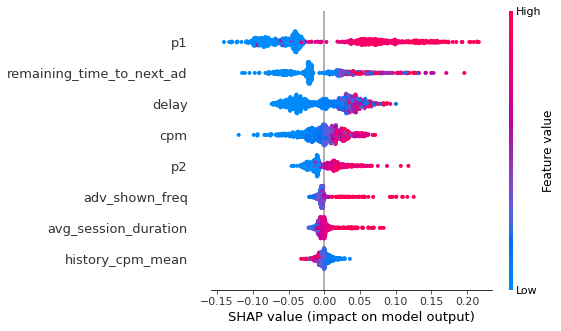

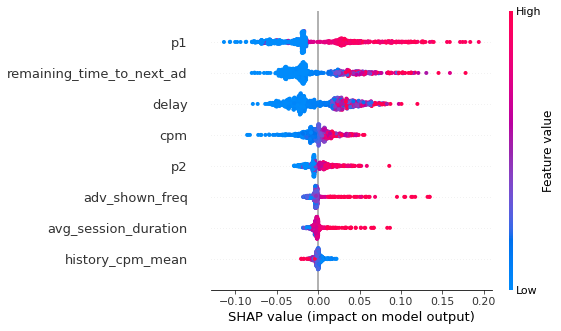

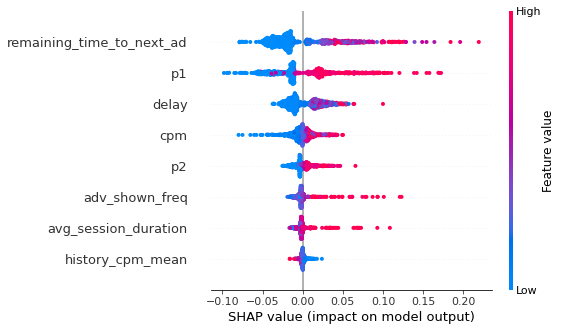

In [ ]:
# shap_test1 = shap.TreeExplainer(model1).shap_values(X_train, y_train['at_least_one'])
# shap.summary_plot(shap_test1, X_train, max_display=69)

# shap_test2 = shap.TreeExplainer(model2).shap_values(X_train, y_train['at_least_two'])
# shap.summary_plot(shap_test2, X_train, max_display=69)

# shap_test3 = shap.TreeExplainer(model3).shap_values(X_train, y_train['at_least_three'])
# shap.summary_plot(shap_test3, X_train, max_display=69)